In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

## Data Intake

In [29]:
# Import local CSV files and change name of EXITS column

df_dec19 = pd.read_csv('v1december_turnstiles.csv', index_col = 0)
df_dec19 = df_dec19.rename(columns={'EXITS                                                               ':'EXITS'})
df_mar20 = pd.read_csv('v1march_turnstiles.csv', index_col = 0)
df_mar20 = df_mar20.rename(columns={'EXITS                                                               ':'EXITS'})
df_june20 = pd.read_csv('v1june_turnstiles.csv', index_col = 0)
df_june20 = df_june20.rename(columns={'EXITS                                                               ':'EXITS'})

In [30]:
new_time = df_dec19.TIME.map(lambda x: str(x)[:-6])
df_dec19['ABBREV_TIME'] = pd.to_numeric(new_time)

new_time = df_mar20.TIME.map(lambda x: str(x)[:-6])
df_mar20['ABBREV_TIME'] = pd.to_numeric(new_time)

new_time = df_june20.TIME.map(lambda x: str(x)[:-6])
df_june20['ABBREV_TIME'] = pd.to_numeric(new_time)

In [31]:
#df_dec19_dailyfoottraffic.groupby(['STATION']).DIFF_FOOTTRAFFIC.agg(['mean','sum']).sort_values('sum', ascending = False).head(10)

In [ ]:
def twoPennStation(dataframe):
    dataframe.loc[(dataframe['STATION'] == '34 ST-PENN STA') & (dataframe['LINENAME'] == '123'), 'STATION'] = '34 ST-PENN EXPRESS'
    # This line will make LINENAME 123ACE categorized as LINENAME ACE
    dataframe.loc[(dataframe['STATION'] == '34 ST-PENN STA') & (dataframe['LINENAME'] == '123ACE'), 'STATION'] = '34 ST-PENN EXPRESS'
    
    dataframe.loc[(dataframe['STATION'] == '34 ST-PENN STA') & (dataframe['LINENAME'] == 'ACE'), 'STATION'] = '34 ST-PENN LOCAL'
    
    return dataframe


In [ ]:
df_dec19 = twoPennStation(df_dec19)
df_mar20 = twoPennStation(mar_dec20)
df_jun20 = twoPennStation(june_dec20)

In [32]:
def hr4FootTraffic(dataframe):
    """
    This function calculated foot traffic for every 4 hour interval.
    It groups the data by TURNSTILE ("C/A", "UNIT", "SCP","STATION"), DATE, TIME, and TIMESTAMP,
    then aggregates it to show the sum (renamed as TOTAL_FOOTTRAFFIC).
    
    The last line for "station_counts_df" is used to calculate the max foot traffic by
    taking the sum of DEC19, MAR20, and JUNE20.
    """
    dataframe['TIMESTAMP'] = pd.to_datetime(dataframe['DATE'] + ' ' + dataframe['TIME'])
    dataframe['FOOTTRAFFIC'] = dataframe['ENTRIES'] + dataframe['EXITS']
    
    # This aggregates FOOTTRAFFIC by STATION & TIME, it also resets the indez
    hour4_counts_df = dataframe.groupby(["C/A", "UNIT", "SCP","STATION","DATE","TIME","TIMESTAMP",'ABBREV_TIME']).FOOTTRAFFIC.agg(['sum', 'count']).reset_index()

    # This creates a new column of DIFF_FOOTRAFFIC by taking the difference in 'sum'
    hour4_counts_df['DIFF_FOOTTRAFFIC'] = hour4_counts_df['sum'].diff()

    # For practical purposes, we will rename 'sum' to TOTAL_FOOTTRAFFIC
    hour4_counts_df = hour4_counts_df.rename(columns={'sum':'TOTAL_FOOTTRAFFIC'})

    return hour4_counts_df

In [33]:
df_dec19_4hrfoottraffic = hr4FootTraffic(df_dec19)
dec_n_of_rows = df_dec19_4hrfoottraffic.shape[0]

df_mar20_4hrfoottraffic = hr4FootTraffic(df_mar20)
mar_n_of_rows = df_mar20_4hrfoottraffic.shape[0]

df_june20_4hrfoottraffic = hr4FootTraffic(df_june20)
june_n_of_rows = df_june20_4hrfoottraffic.shape[0]

In [34]:
def cleanTraffic(dataframe):
    
    #All values below 0 will now also be Not a Number
    dataframe[dataframe['DIFF_FOOTTRAFFIC'] < 0] = np.nan
    
    #Turnstile averages will saved as DIFF_FOOTTRAFFIC aggregate
    grouped = dataframe.groupby(['C/A', 'UNIT', 'SCP','STATION'])['DIFF_FOOTTRAFFIC'].median()
    
    #Then merged to the original dataframe, creating an extra DIFF_FOOTTRAFFIC
    #one will be named DIFF_FOOTTRAFFIC_x , the other DIFF_FOOTTRAFFIC_y
    dataframe = pd.merge(dataframe, grouped,  how='left',
                         left_on=['C/A', 'UNIT', 'SCP','STATION'],
                         right_on = ['C/A', 'UNIT', 'SCP','STATION'])
    
    #A column with original name will be created, filling in nans with means
    dataframe['DIFF_FOOTTRAFFIC'] = dataframe.DIFF_FOOTTRAFFIC_x.fillna(dataframe.DIFF_FOOTTRAFFIC_y)
    
    #Deleting the original, now unconventionally spelled with NaNs in it 
    del dataframe['DIFF_FOOTTRAFFIC_x']
    
    #Keeping a column for turnstile average as needed
    dataframe = dataframe.rename(columns = {'DIFF_FOOTTRAFFIC_y':'MEDIANTRAFFIC'})
    
    #Removing large positive outliers in the dataset 90th percentile
    dataframe = dataframe[dataframe.DIFF_FOOTTRAFFIC < dataframe.DIFF_FOOTTRAFFIC.quantile(.90)]

    return dataframe

In [35]:
df_dec19_4hrfoottraffic = cleanTraffic(df_dec19_4hrfoottraffic)
print('Dec rows ', dec_n_of_rows, ' now: ', df_dec19_4hrfoottraffic.shape[0], '\n')

df_mar20_4hrfoottraffic = cleanTraffic(df_mar20_4hrfoottraffic)
print('Mar rows ', mar_n_of_rows, ' now: ', df_mar20_4hrfoottraffic.shape[0], '\n')

df_june20_4hrfoottraffic = cleanTraffic(df_june20_4hrfoottraffic)
print('June rows ', june_n_of_rows, ' now: ', df_mar20_4hrfoottraffic.shape[0], '\n')

Dec rows  618712  now:  549388 

Mar rows  616471  now:  547565 

June rows  620072  now:  547565 



In [63]:
def turnstileColumn(dataframe):
    '''
    Takes an MTA dataframe & creates a new column
    Where there's an index number for each Turn Stile in frame.
    '''
    eachTS = dataframe.groupby(["C/A", "UNIT", "SCP", "STATION"])[['DIFF_FOOTTRAFFIC']].sum()
    howMany = eachTS.shape[0]
    eachTS['TURNSTILE'] = range(1,(howMany + 1))
    del eachTS['DIFF_FOOTTRAFFIC']
    dataframe = pd.merge(dataframe, eachTS,  how='left',
                         left_on=['C/A','UNIT','SCP', 'STATION'],
                         right_on = ['C/A','UNIT','SCP', 'STATION'])    
    return dataframe

In [65]:
df_dec19_4hrfoottraffic = turnstileColumn(df_dec19_4hrfoottraffic)
df_mar20_4hrfoottraffic = turnstileColumn(df_mar20_4hrfoottraffic)
df_june20_4hrfoottraffic = turnstileColumn(df_june20_4hrfoottraffic)

**Breaking up Penn Station**

In [68]:
df_dec19_4hrfoottraffic.head(2)

,C/A,UNIT,SCP,STATION,DATE,TIME,TIMESTAMP,ABBREV_TIME,TOTAL_FOOTTRAFFIC,count,MEDIANTRAFFIC,DIFF_FOOTTRAFFIC,TURNSTILE
0,A002,R051,02-00-00,59 ST,11/30/2019,03:00:00,2019-11-30 03:00:00,3.0,9761420.0,1.0,294.0,294.0,1
1,A002,R051,02-00-00,59 ST,11/30/2019,07:00:00,2019-11-30 07:00:00,7.0,9761447.0,1.0,294.0,27.0,1


In [67]:
df_dec19_4hrfoottraffic = twoPennStation(df_dec19_4hrfoottraffic)
df_mar20_4hrfoottraffic = twoPennStation(df_mar20_4hrfoottraffic)
df_june20_4hrfoottraffic = twoPennStation(df_june20_4hrfoottraffic)

KeyError: 'LINENAME'

##### Final Check

In [42]:
df_june20_4hrfoottraffic.head(2)

,C/A,UNIT,SCP,STATION,DATE,TIME,TIMESTAMP,ABBREV_TIME,TOTAL_FOOTTRAFFIC,count,MEDIANTRAFFIC,DIFF_FOOTTRAFFIC
0,A002,R051,02-00-00,59 ST,06/06/2020,00:00:00,2020-06-06 00:00:00,0.0,9942049.0,1.0,48.0,48.0
1,A002,R051,02-00-00,59 ST,06/06/2020,04:00:00,2020-06-06 04:00:00,4.0,9942050.0,1.0,48.0,1.0


#### Re-writing anew to csvs

In [59]:
"""
This exports a CSV file that has contains:
(1) difference in foot traffic every 4 hours (DIFF_FOOTTRAFFIC)
(2) Removal of differences that result in negative values or those > 90th percentile (both outliers)
"""

"""
df_dec19_4hrfoottraffic.to_csv('v2_btn_december_turnstiles.csv')
df_mar20_4hrfoottraffic.to_csv('v2_btn_march_turnstiles.csv')
df_june20_4hrfoottraffic.to_csv('v2_btn_june_turnstiles.csv')
""";

## Finding Top Stations

In [60]:
df_dec19_maxfoottraffic = df_dec19_4hrfoottraffic.groupby(["STATION"], as_index=False)["DIFF_FOOTTRAFFIC"].sum()
df_mar20_maxfoottraffic = df_mar20_4hrfoottraffic.groupby(["STATION"], as_index=False)["DIFF_FOOTTRAFFIC"].sum()
df_june20_maxfoottraffic = df_june20_4hrfoottraffic.groupby(["STATION"], as_index=False)["DIFF_FOOTTRAFFIC"].sum()

In [53]:
# Quick checking of DIFF_FOOTTRAFFIC column; looks correct

df_dec19_4hrfoottraffic.head(2)

,C/A,UNIT,SCP,STATION,DATE,TIME,TIMESTAMP,ABBREV_TIME,TOTAL_FOOTTRAFFIC,count,MEDIANTRAFFIC,DIFF_FOOTTRAFFIC
0,A002,R051,02-00-00,59 ST,11/30/2019,03:00:00,2019-11-30 03:00:00,3.0,9761420.0,1.0,294.0,294.0
1,A002,R051,02-00-00,59 ST,11/30/2019,07:00:00,2019-11-30 07:00:00,7.0,9761447.0,1.0,294.0,27.0



Checking the top 20 most trafficked stations; the majority in top 10 match

In [54]:
# Checking the top 20 most trafficked stations; the majority in top 10 match

total_foottraffic = df_dec19_maxfoottraffic.set_index('STATION').\
    join(df_mar20_maxfoottraffic.set_index('STATION'), lsuffix = '_DEC').\
    join(df_june20_maxfoottraffic.set_index('STATION'), lsuffix = '_MAR', rsuffix = '_JUNE')

total_foottraffic['DIFF_FOOTTRAFFIC_TOTAL'] = total_foottraffic['DIFF_FOOTTRAFFIC_DEC'] +\
    total_foottraffic['DIFF_FOOTTRAFFIC_JUNE'] + total_foottraffic['DIFF_FOOTTRAFFIC_MAR']

total_foottraffic = total_foottraffic.sort_values('DIFF_FOOTTRAFFIC_TOTAL', ascending=False).reset_index()

total_foottraffic_top10 = total_foottraffic.sort_values('DIFF_FOOTTRAFFIC_TOTAL', ascending=False).reset_index().head(10)

total_foottraffic_top10

,index,STATION,DIFF_FOOTTRAFFIC_DEC,DIFF_FOOTTRAFFIC_MAR,DIFF_FOOTTRAFFIC_JUNE,DIFF_FOOTTRAFFIC_TOTAL
0,0,34 ST-PENN STA,2884012.0,911461.0,496419.0,4291892.0
1,1,FULTON ST,1983448.0,654067.0,355076.0,2992591.0
2,2,23 ST,1905650.0,605035.0,326204.0,2836889.0
3,3,86 ST,1706099.0,600540.0,297415.0,2604054.0
4,4,GRD CNTRL-42 ST,1580469.0,600121.0,200067.0,2380657.0
5,5,59 ST,1553536.0,465495.0,222464.0,2241495.0
6,6,CANAL ST,1516187.0,418639.0,214003.0,2148829.0
7,7,34 ST-HERALD SQ,1356545.0,508357.0,256336.0,2121238.0
8,8,125 ST,1374726.0,517337.0,219002.0,2111065.0
9,9,42 ST-PORT AUTH,1447790.0,425339.0,136271.0,2009400.0


In [56]:
total_foottraffic.sort_values(['DIFF_FOOTTRAFFIC_TOTAL'], ascending = False).head(20);

## Plotting Results

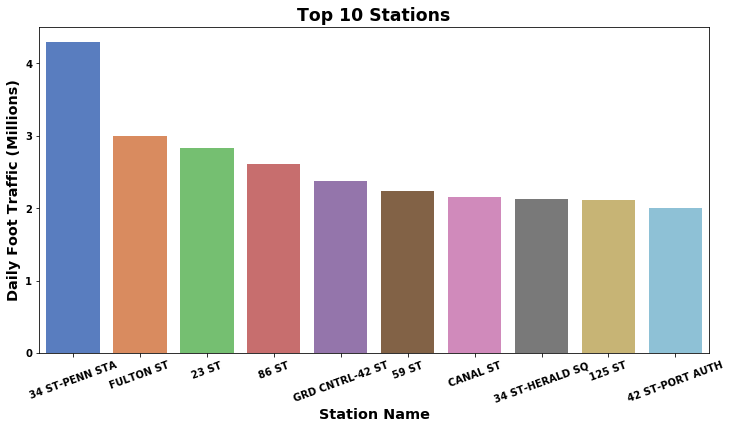

In [57]:
# Top 10 Stations Plot

plt.figure(figsize=[12, 6])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

ax1 = sns.barplot(x = 'STATION', y = total_foottraffic_top10['DIFF_FOOTTRAFFIC_TOTAL']/1e6,
                  data = total_foottraffic_top10,
                  palette = "muted",)
plt.xticks(rotation=20)
ax1.set_xlabel('Station Name', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Daily Foot Traffic (Millions)', fontdict=font, fontsize='x-large')
plt.title('Top 10 Stations', fontdict=font, fontsize='xx-large');

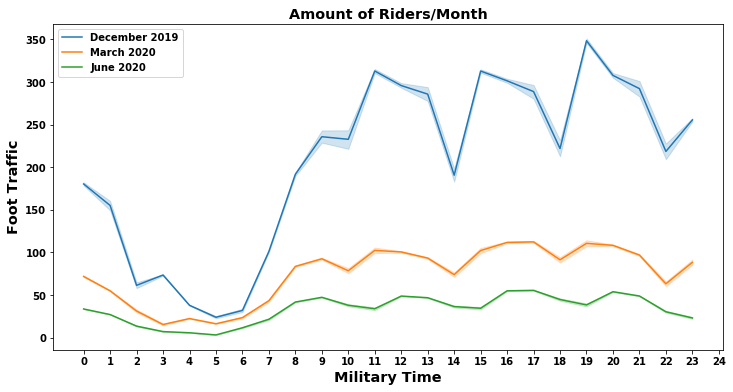

In [58]:
plt.figure(figsize=[12, 6])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

# December 2019 data
ax1 = sns.lineplot(x = 'ABBREV_TIME', y = df_dec19_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                  data = df_dec19_4hrfoottraffic,
                  palette = "muted",)

# March 2020 data
sns.lineplot(x = 'ABBREV_TIME', y = df_mar20_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                     data = df_mar20_4hrfoottraffic,
                     palette = "muted", ax = ax1)

# June 2020 data
sns.lineplot(x = 'ABBREV_TIME', y = df_june20_4hrfoottraffic['DIFF_FOOTTRAFFIC'],
                     data = df_june20_4hrfoottraffic,
                     palette = "muted", ax = ax1)

ax1.set_xlabel('Military Time', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Foot Traffic', fontdict=font, fontsize='x-large')

plt.legend(['December 2019', 'March 2020', 'June 2020'])
plt.xticks(rotation=0)
plt.xticks(np.arange(0, 25, 1.0))
plt.title('Amount of Riders/Month', fontdict=font, fontsize='x-large');